* 几个重要的点:
    
    Fixed Q-target(定时共享参数)
    
    Experience Repaly Memory(numpy)
    
    Gradient clipping(增加稳定性)

In [1]:
import os
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

In [2]:
class ReplayBuffer:
    def __init__(self, column, max_size, batch_size):
        self.current_state = np.zeros((max_size, column), dtype=np.float32)
        self.next_state = np.zeros((max_size, column), dtype=np.float32)
        self.action = np.zeros(max_size, dtype=np.float32)
        self.reward = np.zeros(max_size, dtype=np.float32)
        self.done = np.zeros(max_size,dtype=np.float32)
        self.max_size, self.batch_size = max_size, batch_size
        self.size, self.current_index = 0, 0
    
    def store(self, current_state, action, next_state, reward, done):
        self.current_state[self.current_index] = current_state
        self.action[self.current_index] = action
        self.next_state[self.current_index] = next_state
        self.reward[self.current_index] = reward
        self.done[self.current_index] = done
        self.current_index = (self.current_index + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def sample_batch(self):
        ptr = np.random.choice(self.size, self.batch_size)
        return dict(current_state=self.current_state[ptr],
                    next_state=self.next_state[ptr],
                    action=self.action[ptr],
                    reward=self.reward[ptr],
                    done=self.done[ptr]
        )
    
    def __len__(self):
        return self.size

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Network, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self,x):
        return self.layers(x)

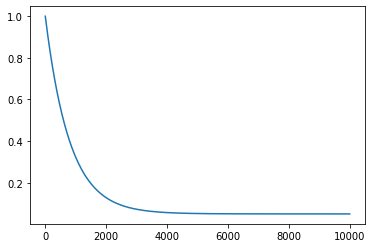

In [4]:
min_epsilon = 0.05
max_epsilon = 1
epsilon_decay = 800
epsilon_episode = lambda episode : min_epsilon + np.exp(-episode / epsilon_decay)*0.95
plt.plot([epsilon_episode(x) for x in range(10000)])

In [5]:
env_name = 'CartPole-v0'
# env_name = "LunarLander-v2"

env = gym.make(env_name)
in_dim = env.observation_space.shape[0]
out_dim = env.env.action_space.n

seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

batch_size = 32
max_size = 1000
memory = ReplayBuffer(env.observation_space.shape[0], max_size, batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

network = Network(in_dim, out_dim).to(device)
target_network = Network(in_dim, out_dim).to(device)
target_network.load_state_dict(network.state_dict())
target_network.eval() # 把train设置为false，默认为true。可通过target_network.train()将train设置回true

optimizer = optim.Adam(network.parameters(), lr=1e-3)

gamma = 0.99
target_update = 200

In [6]:
def select_action(episode, state):
    if np.random.random_sample() > epsilon_episode(episode):
        selected_action = network(torch.FloatTensor(state).to(device)).argmax().detach().cpu().numpy()
    else:
        selected_action = env.action_space.sample()
    return selected_action

In [7]:
def train():
    samples = memory.sample_batch()
    state = torch.FloatTensor(samples["current_state"]).to(device).to(device)
    next_state = torch.FloatTensor(samples["next_state"]).to(device)
    action = torch.LongTensor(samples["action"].reshape(-1, 1)).to(device)
    reward = torch.FloatTensor(samples["reward"].reshape(-1, 1)).to(device)
    done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
    
    current_Q_value = network(state).gather(1, action)
#     gather : 对源多维数组的信息从新提取,第一个参数代表跨行(0)&跨列(1)
#     tensor[[1,2],    index[[0,0],
#            [3,4]]          [1,0]]
#     dim = 0 return [[1,2],   dim = 1 return [[1,1],
#                     [3,2]]                    [4,3]]
    next_Q_value = target_network(next_state).max(dim=1,keepdim=True)[0].detach()
#     .max()
#         keepdim=True,保持原来的形状，如:(2,3) \to (2,1)
#     返回值有values 和 indices 所以要有[0]操作
#     detach()
#         共享tensor() not require grad
    target = (reward + gamma*next_Q_value*(1 - done)).to(device)
    loss = ((target - current_Q_value).pow(2)).mean()
    optimizer.zero_grad()
    loss.backward()
    clip_grad_norm_(network.parameters(),1.0,norm_type=1) # Gradient clipping(增加稳定性)
    optimizer.step()

In [8]:
def plot_reward(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.title('frame %s. mean_reward: %s'%(frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.xlabel('epoch')
    plt.ylabel('reward')
    plt.show()

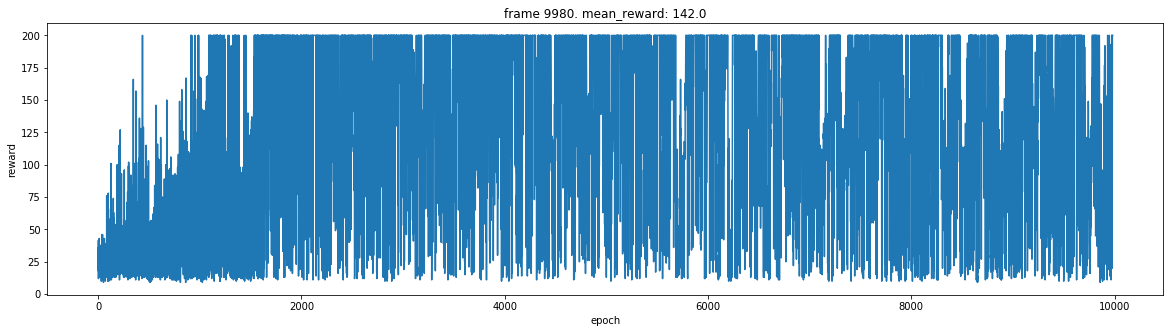

In [9]:
all_rewards = []
update_count = 0

for episode in range(10000):
    state, rewards = env.reset(), 0
    for i in range(10000):
        action = select_action(episode, state)
        next_state, reward, done, _ = env.step(action)
        memory.store(state, action, next_state, reward, done)
        state = next_state
        rewards += reward
        if done:
            break
        if len(memory) > batch_size:
            train()
            update_count += 1
            if update_count % target_update == 0:
                target_network.load_state_dict(network.state_dict())     
    all_rewards.append(rewards)
    
    if episode % 20 == 0:
        plot_reward(episode,all_rewards)

In [10]:
test_episodes = 100
test_steps = 300

def test_dqn():
    test_rewards = []
    for _ in range(test_episodes):
        state = env.reset()
        rewards = 0
        for _ in range(test_steps):
            with torch.no_grad():
                action = network(torch.FloatTensor(state).to(device)).argmax().detach().cpu().numpy()
            next_state, reward, done, _ = env.step(action.item())
            state = next_state
            rewards += reward
            if done: break
            
        test_rewards.append(rewards)
    return test_rewards

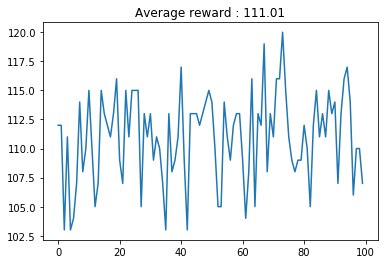

In [11]:
test_result = test_dqn()
plt.title("Average reward : {}".format(np.array(test_result).mean()))
plt.plot(test_result)